# Reviews summarization

### Import libraries that we will be using

In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import gensim
import os

from itertools import chain
from sklearn import feature_extraction
from sklearn import pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm 

import textwrap
import mako
from mako.template import Template

import sklearn.metrics as metrics
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore")

from gensim.models import FastText
import fasttext
ft_model=FastText.load('C:/Users/Надежда/model.fasttext2203.bin')

c:\users\надежда\appdata\local\programs\python\python36\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\users\надежда\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\надежда\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


### Parse the data as a pandas object

In [621]:
#The dataset marked up manually
df_small=pd.read_csv('annotated data.csv', usecols=['category', 'uid', 'model_id', 'part','sentences', 'aspect', 'sentiment', 'train_test'])

#The dataset that we will use for our dataset expansion
df_for_expansion=pd.read_csv('reviews_5_categories_for expansion.csv', usecols=['category', 'uid', 'model_id', 'part','sentences', 'origin_form'])

#Keywords that we will use for our dataset expansion
keywords=pd.read_csv('keywords_for expansion.csv')

### Cleaning the datasets

In [624]:
#Clean datasets
lst_stopwords = nltk.corpus.stopwords.words("russian")

def clean_data(text, lst_stopwords=None, remove_ne=False):
    if remove_ne==False:
        lst_stopwords=lst_stopwords
    else:
        if 'не' in lst_stopwords:
            lst_stopwords.remove('не')
            lst_stopwords.remove('нет')
            
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    #text=re.sub("\d+", " ", text)
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [623]:
df_small["text_clean"] = df_small["sentences"].apply(lambda x: clean_data(x, lst_stopwords=lst_stopwords, remove_ne=False))
df_small['tokenized_sents'] = df_small.apply(lambda row: nltk.word_tokenize(row['text_clean']), axis=1)

df_for_expansion["text_clean"] = df_for_expansion["sentences"].apply(lambda x: clean_data(x, lst_stopwords=lst_stopwords, remove_ne=False))
df_for_expansion['tokenized_sents'] = df_for_expansion.apply(lambda row: nltk.word_tokenize(row['text_clean']), axis=1)
df_for_expansion['train_test']='train'

### 0. Сreating expanded datasets

In [436]:
#Define function for extraction sentences that contain keywords
def filter_by_keywords(df, keywords):
    resultdf=pd.DataFrame()
    cat_list=keywords[keywords.category!='all'].category.unique().tolist()
    class_list=keywords['class_word'].unique().tolist()
    for cat in cat_list:
        df1=df[df.category==cat]
        for cl in class_list:
            l=keywords[(keywords.category=='all')&(keywords.class_word==cl)].keyword.unique().tolist()+\
            keywords[(keywords.category==cat)&(keywords.class_word==cl)].keyword.unique().tolist()
            df1[str(cl)] = np.where(df1.sentences.str.contains(str.join('|',l),regex=True), 1, 0)
        resultdf=pd.concat([resultdf,df1]) 
    return resultdf

In [437]:
df_raw_expanded=filter_by_keywords(df_for_expansion, keywords)

In [438]:
def set_y(row):
    aspect_list=['construction','aesthetic','functionality', 'exploitation','price','general']
    for asp in aspect_list:
        if row[asp] == 1:
            return asp
df_raw_expanded = df_raw_expanded.assign(aspect=df_raw_expanded.apply(set_y, axis=1))

In [439]:
df_raw_expanded['num_aspect']=df_raw_expanded['aesthetic']+df_raw_expanded['price']+df_raw_expanded['construction']+\
                                df_raw_expanded['exploitation']+df_raw_expanded['functionality']+df_raw_expanded['general']
df_raw_expanded=df_raw_expanded[(df_raw_expanded.num_aspect==1)]
df_raw_expanded=df_raw_expanded[(~df_raw_expanded.aspect.isna())].drop_duplicates(subset=['category','text_clean', 'aspect'])

In [440]:
df_raw_expanded.shape

(186835, 17)

In [441]:
#Define functions for vector representation of sentences using FastText embeddings 
#We will use centroid method (http://www2.aueb.gr/users/ion/docs/BioNLP_2016.pdf)

n=50 #embed_dim
def get_tfidf(docs, ngram_range=(1,1), index=None):
            vect = feature_extraction.text.TfidfVectorizer(ngram_range=ngram_range, max_features=5000)
            tfidf = vect.fit_transform(docs).todense()
            return pd.DataFrame(tfidf, columns=vect.get_feature_names(), index=index).T
        
def get_sentence_embeddings(embedding_model, list_sentences, tfidf):
            sent_embs = []
            for desc in range(len(list_sentences)):
                sent_emb = np.zeros((1, n))
                if len(list_sentences[desc]) > 0:
                    sent_emb = np.zeros((1, n))
                    div = 0
                    model = embedding_model
                    for word in list_sentences[desc]:
                        if type(embedding_model.wv[word])==np.ndarray and word in tfidf.index:
                            word_emb = model.wv[word]
                            weight = tfidf.loc[word, 'Doc {:d}'.format(desc)]
                            sent_emb = np.add(sent_emb, word_emb * weight)
                            div += weight     
                           
                        else:
                            div += 1e-13 #to avoid dividing by 0
                        
                if div == 0:
                    print(desc)

                sent_emb = np.divide(sent_emb, div)
                sent_embs.append(sent_emb.flatten())
            return sent_embs
        
def get_ft_vec(df_original):
    resultdf=pd.DataFrame()
    cat_list=df_original.category.unique().tolist()
    for cat in cat_list:
        df=df_original[df_original.category==cat]
        df_train=df[(df.train_test=='train')]
        df_test=df[(df.train_test=='test')]
        merged_sentences_train = df_train["text_clean"].tolist()
        document_names_train = ['Doc {:d}'.format(i) for i in range(len(merged_sentences_train))]
        tfidf_train = get_tfidf(merged_sentences_train, ngram_range=(1,1), index=document_names_train)
        filtered_sentences_train=df_train['tokenized_sents'].tolist()
        X_train=get_sentence_embeddings(embedding_model = ft_model, list_sentences=filtered_sentences_train, tfidf=tfidf_train)
        df_train['vec_ft']=X_train
        
        if df_test.shape[0]>0:
            merged_sentences_test = df_test["text_clean"].tolist()
            document_names_test = ['Doc {:d}'.format(i) for i in range(len(merged_sentences_test))]
            tfidf_test = get_tfidf(merged_sentences_test, ngram_range=(1,1), index=document_names_test)  
            filtered_sentences_test=df_test['tokenized_sents'].tolist()
            X_test=get_sentence_embeddings(embedding_model = ft_model, list_sentences=filtered_sentences_test, tfidf=tfidf_test)
            df_test['vec_ft']=X_test
        

        resultdf=pd.concat([resultdf,df_train])
        resultdf=pd.concat([resultdf,df_test]) 
    
    return resultdf

In [442]:
df_small=get_ft_vec(df_small)
df_raw_expanded=get_ft_vec(df_raw_expanded)

In [669]:
df_small.groupby(['category', 'train_test']).agg(count_rew=('uid', 'nunique'), count_sent=('sentences', 'count'))

count_rew  count_sent
category          train_test                       
Кофемашины        test              204         596
                  train             171         412
Роботы-пылесосы   test              157         597
                  train             147         409
Стиральные машины test              173         530
                  train             151         352
Телевизоры        test              121         589
                  train             114         402
Электронные книги test              117         599
                  train             111         402

In [444]:
df_raw_expanded=df_raw_expanded[['category', 'uid', 'model_id', 'part','sentences', 'aspect', 'text_clean', 'tokenized_sents','train_test', 'vec_ft']]

In [445]:
df_raw_expanded.shape

(186835, 10)

In [446]:
def get_cosine_similarity(df_labeled, df_full):
    cos_data = pd.DataFrame(columns=df_full.columns)
    cos_data['cos']=''
    cat_list=df_labeled.category.unique().tolist()
    asp_list=df_labeled.aspect.unique().tolist()  
    for cat in cat_list:
        for asp in asp_list:
            l=[]
            ll=[]
            df1=df_labeled[(df_labeled.category==cat)&(df_labeled.aspect==asp)&(df_labeled.train_test=='train')]
            df2=df_full[(df_full.category==cat)&(df_full.aspect==asp)&(df_full.train_test=='train')]
            l1=df1.vec_ft.tolist()
            l2=df2.vec_ft.tolist()
            for el in l2:
                l=[]
                for i in range(len(l1)):
                    cos=np.dot(el,l1[i])/(norm(el)*norm(l1[i]))
                    l.append(cos)
                ll.append(l)
            df2['cos']=ll
            cos_data = cos_data.append(df2)
    return cos_data

In [447]:
df_raw_expanded_cs=get_cosine_similarity(df_small, df_raw_expanded)

In [448]:
df_raw_expanded_cs['max_cosine']=df_raw_expanded_cs.cos.apply(lambda x: max(x))

In [449]:
df_raw_expanded_cs=df_raw_expanded_cs[(~df_raw_expanded_cs.max_cosine.isna())]

In [450]:
df_raw_expanded_cs=df_raw_expanded_cs.sort_values(by=['category','aspect', 'max_cosine'], ascending=False)

In [451]:
df_raw_expanded_cs.shape

(186190, 12)

In [452]:
def get_expanded(df_labeled, df_raw, n):
    expanded_data = pd.DataFrame(columns=df_raw.columns)
    cat_list=df_labeled.category.unique().tolist()
    asp_list=df_labeled.aspect.unique().tolist()
    for cat in cat_list:
        for asp in asp_list:
            cur_num=df_labeled[(df_labeled.category==cat)&(df_labeled.aspect==asp)&(df_labeled.train_test=='train')].shape[0]*n
            expanded_data = expanded_data.append(df_raw[(df_raw.category==cat)&(df_raw.aspect==asp)][0 : cur_num + 1])
    return expanded_data

In [453]:
#creating 3 datasets of different sizes
expanded_df_10=get_expanded(df_small, df_raw_expanded_cs, 10)
expanded_df_30=get_expanded(df_small, df_raw_expanded_cs, 30)
expanded_df_50=get_expanded(df_small, df_raw_expanded_cs, 50)

In [454]:
expanded_df_10.shape, expanded_df_30.shape, expanded_df_50.shape

((19800, 12), (58093, 12), (93514, 12))

In [455]:
df_small['part_data']='original'
expanded_df_10['part_data']='expanded'
expanded_df_30['part_data']='expanded'
expanded_df_50['part_data']='expanded'


In [456]:
expanded_df_10.loc[expanded_df_10.part=='minuses', 'sentiment']='negative'
expanded_df_10.loc[expanded_df_10.part=='pluses', 'sentiment']='positive'
expanded_df_30.loc[expanded_df_30.part=='minuses', 'sentiment']='negative'
expanded_df_30.loc[expanded_df_30.part=='pluses', 'sentiment']='positive'
expanded_df_50.loc[expanded_df_50.part=='minuses', 'sentiment']='negative'
expanded_df_50.loc[expanded_df_50.part=='pluses', 'sentiment']='positive'

In [457]:
expanded_df_10_full = pd.concat([df_small[['category', 'uid', 'model_id', 'part', 'sentences', 'aspect',
       'train_test', 'vec_ft', 'text_clean', 'tokenized_sents','part_data', 'sentiment']],expanded_df_10[['category', 'uid', 'model_id', 'part', 'sentences', 'aspect',
       'train_test', 'vec_ft', 'text_clean', 'tokenized_sents','part_data', 'sentiment']]], ignore_index=True, sort=False)

expanded_df_30_full = pd.concat([df_small[['category', 'uid', 'model_id', 'part', 'sentences', 'aspect',
       'train_test', 'vec_ft', 'text_clean', 'tokenized_sents','part_data', 'sentiment']],expanded_df_30[['category', 'uid', 'model_id', 'part', 'sentences', 'aspect',
       'train_test', 'vec_ft', 'text_clean', 'tokenized_sents','part_data', 'sentiment']]], ignore_index=True, sort=False)

expanded_df_50_full = pd.concat([df_small[['category', 'uid', 'model_id', 'part', 'sentences', 'aspect',
       'train_test', 'vec_ft', 'text_clean', 'tokenized_sents','part_data', 'sentiment']],expanded_df_50[['category', 'uid', 'model_id', 'part', 'sentences', 'aspect',
       'train_test', 'vec_ft', 'text_clean', 'tokenized_sents','part_data', 'sentiment']]], ignore_index=True, sort=False)

In [458]:
df_expanded_10=expanded_df_10_full[~(expanded_df_10_full.text_clean.isna())&~(expanded_df_10_full.text_clean=='')]
df_expanded_30=expanded_df_30_full[~(expanded_df_30_full.text_clean.isna())&~(expanded_df_30_full.text_clean=='')]
df_expanded_50=expanded_df_50_full[~(expanded_df_50_full.text_clean.isna())&~(expanded_df_50_full.text_clean=='')]

In [629]:
df_expanded_30.shape

(62982, 13)

In [628]:
df_expanded_30=df_expanded_30[df_expanded_30.sentences!='но в руке лежит удобно']

In [459]:
df_expanded_10.to_csv('expanded_data_10.csv')
df_expanded_30.to_csv('expanded_data_30.csv')
df_expanded_50.to_csv('expanded_data_50.csv')

### 1. Creating a TF-IDF model on small dataset as Baseline

In [460]:
def get_train_test_tfidf(df_original):
    train_test={}
    category_list = df_original['category'].unique().tolist()
    for cat in category_list:
        #print(cat)
        train_test[cat]={}
        df=df_original[df_original.category==cat]
        df_train=df[(df.train_test=='train')]
        df_test=df[(df.train_test=='test')]
        y_train=df_train["aspect"].values
        y_test=df_test["aspect"].values
        
        vectorizer = feature_extraction.text.TfidfVectorizer(max_features=5000, ngram_range=(1,2))

        corpus_train = df_train["text_clean"]
        vectorizer.fit(corpus_train)
        X_train = vectorizer.transform(corpus_train).toarray()
        dic_vocabulary = vectorizer.vocabulary_
        
        corpus_test = df_test["text_clean"]
        X_test = vectorizer.transform(corpus_test).toarray()

        
        train_test[cat]['y_test']=y_test
        train_test[cat]['y_train']=y_train
        train_test[cat]['X_test']=X_test
        train_test[cat]['X_train']=X_train
    
    return train_test 

In [461]:
train_test_tfidf=get_train_test_tfidf(df_small)

### 2. Creating a FastText models on small and expanded datasets

In [462]:
def get_train_test_ft(df_original):
    train_test={}
    category_list = df_original['category'].unique().tolist()
    for cat in category_list:
        train_test[cat]={}
        df=df_original[df_original.category==cat]
        df_train=df[(df.train_test=='train')]
        df_train=df_train.reset_index()
        df_test=df[(df.train_test=='test')]
        df_test=df_test.reset_index()
        y_train=df_train["aspect"].tolist()
        y_test=df_test["aspect"].tolist()
        X_train=df_train["vec_ft"].tolist()
        X_test=df_test["vec_ft"].tolist()
        train_test[cat]['y_test']=y_test
        train_test[cat]['y_train']=y_train
        train_test[cat]['X_test']=X_test
        train_test[cat]['X_train']=X_train
    
    return train_test 

In [463]:
train_test_ft_small=get_train_test_ft(df_small)

In [464]:
train_test_ft_expanded_10=get_train_test_ft(df_expanded_10)

In [465]:
train_test_ft_expanded_30=get_train_test_ft(df_expanded_30)

In [466]:
train_test_ft_expanded_50=get_train_test_ft(df_expanded_50)

### 3. Performing grid search on multiple models

In [467]:
# Create list for tuning on multiple models
my_models = [
    {'model':svm.SVC, 'params':{
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 200, 1000],
    'kernel': ['linear','rbf']
    }},
    {'model':DecisionTreeClassifier, 'params':{
    'max_depth':[10,15,20,30],
    'criterion': ['gini','entropy']
    }},
    {'model':GaussianNB, 'params': {}
    },
    {'model': KNeighborsClassifier, 'params': 
    {"n_neighbors": range(3, 16), 
    "weights":["uniform", "distance"]
    }},
    {'model': RandomForestClassifier, 'params':{ 
    'n_estimators': [10, 50, 100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
    }},
    {'model': GradientBoostingClassifier, 'params':{
    "max_features":["log2","sqrt"],
    "n_estimators":[10, 50,100, 200, 300, 500]
    }}
]

In [468]:
best_models = [
    {'model':svm.SVC, 'params':{
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 200, 1000],
    'kernel': ['linear','rbf']
    }},
    {'model': KNeighborsClassifier, 'params': 
    {"n_neighbors": range(3, 16), 
    "weights":["uniform", "distance"]
    }},
    {'model': RandomForestClassifier, 'params':{ 
    'n_estimators': [10, 50, 100, 200, 300, 500],
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
    }}
]

In [469]:
# Define functions for performing hyperparameter tuning on multiple models
def get_best_params(dict_train_test, dict_models):
    models_best_params={}
    for cat in dict_train_test.keys():
        models_best_params[cat]={}
        for model in dict_models:
            gridsearch = GridSearchCV(model['model'](), model['params'], cv=3, n_jobs=-1, scoring='f1_macro')
            gridsearch.fit(dict_train_test[cat]['X_train'], dict_train_test[cat]['y_train'])  
            models_best_params[cat][model['model']] = gridsearch.best_params_
   
    return models_best_params

In [470]:
models_best_params_tfidf=get_best_params(train_test_tfidf, my_models)

In [471]:
models_best_params_ft_small=get_best_params(train_test_ft_small, best_models)

In [472]:
models_best_params_ft_expanded_10=get_best_params(train_test_ft_expanded_10, best_models)

In [473]:
models_best_params_ft_expanded_30=get_best_params(train_test_ft_expanded_30, best_models)

In [474]:
models_best_params_ft_expanded_50=get_best_params(train_test_ft_expanded_50, best_models)

In [678]:
models_best_params = open('models_best_params.txt', 'a')

In [682]:
import json
with open('models_best_params.json', 'w') as fp:
    json.dump(str(models_best_params_tfidf), fp)

In [680]:
models_best_params.write(str(models_best_params_tfidf))

2897

### 4. Classifying sentences into 6 classes
We will do classification into 6 classes (<i>aesthetic, construction, exploitation, functionality, general, price<i>) for 5 different products:
<i><ul>
<li>television</li>
<li>vacuum cleaner</li>
<li>e-book</li>
<li>coffee machine</li>
<li>washing machine</li>
</ul> <i>

In [673]:
# Define functions for classifying
def get_classify(dict_train_test, dict_best_params, list_models, with_best_params=False):
    df_metrics = pd.DataFrame(columns=['category', 'model', 'f1_score_macro', 'f1_score_micro'])
    for cat in dict_train_test.keys():
        for cur_model in list_models:
            print(cat, cur_model['model'])
            if with_best_params==True:
                model = pipeline.Pipeline([("classifier", cur_model['model'](**dict_best_params[cat][cur_model['model']]))])
            else:
                model = pipeline.Pipeline([("classifier", cur_model['model']())])
            model.fit(dict_train_test[cat]['X_train'], dict_train_test[cat]['y_train'])
            predicted = model.predict(dict_train_test[cat]['X_test'])
            y_test=dict_train_test[cat]['y_test']
            accuracy = metrics.accuracy_score(y_test, predicted)
            f1_score_micro = metrics.f1_score(y_test, predicted,average='micro')
            f1_score_macro = metrics.f1_score(y_test, predicted,average='macro')
            f1_score_weighted = metrics.f1_score(y_test, predicted,average='weighted')
            d = {'category': cat, 'model': str(cur_model['model']), 'f1_score_micro': round(f1_score_micro,2), 'f1_score_macro':round(f1_score_macro,2)}
            df = pd.DataFrame(data=d, index=[0])
            df_metrics = df_metrics.append(df)

            print("f1_score_micro:",  round(f1_score_micro,3))
            print("f1_score_macro:",  round(f1_score_macro,3))
            print("Detail:")
            print(metrics.classification_report(y_test, predicted))
    return df_metrics

In [476]:
df_metrics_tfidf=get_classify(train_test_tfidf, models_best_params_tfidf, my_models, with_best_params=True)

Телевизоры <class 'sklearn.svm.classes.SVC'>
f1_score_micro: 0.8
f1_score_macro: 0.71
Detail:
               precision    recall  f1-score   support

    aesthetic       1.00      0.42      0.59        12
 construction       0.83      0.42      0.56        24
 exploitation       0.83      0.69      0.75       145
functionality       0.76      0.96      0.85       304
      general       0.93      0.50      0.65        50
        price       0.95      0.76      0.85        55

     accuracy                           0.80       590
    macro avg       0.88      0.62      0.71       590
 weighted avg       0.82      0.80      0.79       590

Телевизоры <class 'sklearn.tree.tree.DecisionTreeClassifier'>
f1_score_micro: 0.73
f1_score_macro: 0.62
Detail:
               precision    recall  f1-score   support

    aesthetic       1.00      0.42      0.59        12
 construction       1.00      0.21      0.34        24
 exploitation       0.86      0.46      0.59       145
functionality       

f1_score_micro: 0.65
f1_score_macro: 0.54
Detail:
               precision    recall  f1-score   support

    aesthetic       0.67      0.32      0.43        19
 construction       0.96      0.57      0.71        44
 exploitation       0.61      0.91      0.73       298
functionality       0.89      0.36      0.51       152
      general       0.51      0.46      0.48        61
        price       1.00      0.24      0.39        25

     accuracy                           0.65       599
    macro avg       0.77      0.48      0.54       599
 weighted avg       0.72      0.65      0.63       599

Электронные книги <class 'sklearn.naive_bayes.GaussianNB'>
f1_score_micro: 0.64
f1_score_macro: 0.56
Detail:
               precision    recall  f1-score   support

    aesthetic       0.23      0.58      0.33        19
 construction       0.79      0.61      0.69        44
 exploitation       0.80      0.65      0.72       298
functionality       0.60      0.70      0.65       152
      genera

f1_score_macro: 0.71
Detail:
               precision    recall  f1-score   support

    aesthetic       0.44      0.95      0.60        39
 construction       0.78      0.70      0.74        61
 exploitation       0.78      0.74      0.76       168
functionality       0.86      0.74      0.79       155
      general       0.80      0.71      0.75        83
        price       0.60      0.62      0.61        24

     accuracy                           0.74       530
    macro avg       0.71      0.74      0.71       530
 weighted avg       0.77      0.74      0.75       530

Стиральные машины <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
f1_score_micro: 0.76
f1_score_macro: 0.78
Detail:
               precision    recall  f1-score   support

    aesthetic       0.94      0.85      0.89        39
 construction       0.95      0.62      0.75        61
 exploitation       0.65      0.78      0.71       168
functionality       0.80      0.77      0.79       155
      gene

In [674]:
df_metrics_ft_small=get_classify(train_test_ft_small, models_best_params_ft_small, best_models, with_best_params=True)

Телевизоры <class 'sklearn.svm.classes.SVC'>
f1_score_micro: 0.856
f1_score_macro: 0.814
Detail:
               precision    recall  f1-score   support

    aesthetic       0.79      0.92      0.85        12
 construction       0.75      0.50      0.60        24
 exploitation       0.77      0.80      0.79       145
functionality       0.88      0.91      0.90       304
      general       0.86      0.76      0.81        50
        price       0.98      0.91      0.94        55

     accuracy                           0.86       590
    macro avg       0.84      0.80      0.81       590
 weighted avg       0.86      0.86      0.85       590

Телевизоры <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
f1_score_micro: 0.815
f1_score_macro: 0.745
Detail:
               precision    recall  f1-score   support

    aesthetic       0.83      0.83      0.83        12
 construction       0.82      0.38      0.51        24
 exploitation       0.77      0.74      0.76       145
fu

f1_score_micro: 0.823
f1_score_macro: 0.813
Detail:
               precision    recall  f1-score   support

    aesthetic       0.77      0.95      0.85        39
 construction       0.91      0.82      0.86        61
 exploitation       0.80      0.82      0.81       168
functionality       0.86      0.86      0.86       155
      general       0.76      0.73      0.75        83
        price       0.84      0.67      0.74        24

     accuracy                           0.82       530
    macro avg       0.82      0.81      0.81       530
 weighted avg       0.82      0.82      0.82       530

Стиральные машины <class 'sklearn.ensemble.forest.RandomForestClassifier'>
f1_score_micro: 0.823
f1_score_macro: 0.801
Detail:
               precision    recall  f1-score   support

    aesthetic       0.97      0.79      0.87        39
 construction       0.89      0.69      0.78        61
 exploitation       0.73      0.88      0.80       168
functionality       0.88      0.88      0.88   

In [675]:
df_metrics_ft_expanded_10=get_classify(train_test_ft_expanded_10, models_best_params_ft_expanded_10, best_models, with_best_params=True)

Телевизоры <class 'sklearn.svm.classes.SVC'>
f1_score_micro: 0.851
f1_score_macro: 0.809
Detail:
               precision    recall  f1-score   support

    aesthetic       0.77      0.83      0.80        12
 construction       0.58      0.75      0.65        24
 exploitation       0.78      0.80      0.79       145
functionality       0.90      0.89      0.90       304
      general       0.92      0.68      0.78        50
        price       0.89      0.98      0.93        55

     accuracy                           0.85       590
    macro avg       0.81      0.82      0.81       590
 weighted avg       0.86      0.85      0.85       590

Телевизоры <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
f1_score_micro: 0.851
f1_score_macro: 0.812
Detail:
               precision    recall  f1-score   support

    aesthetic       0.77      0.83      0.80        12
 construction       0.72      0.75      0.73        24
 exploitation       0.79      0.83      0.81       145
fu

f1_score_micro: 0.815
f1_score_macro: 0.795
Detail:
               precision    recall  f1-score   support

    aesthetic       0.60      0.97      0.75        39
 construction       0.79      0.90      0.84        61
 exploitation       0.84      0.82      0.83       168
functionality       0.87      0.83      0.85       155
      general       0.86      0.69      0.77        83
        price       0.84      0.67      0.74        24

     accuracy                           0.82       530
    macro avg       0.80      0.81      0.80       530
 weighted avg       0.83      0.82      0.82       530

Стиральные машины <class 'sklearn.ensemble.forest.RandomForestClassifier'>
f1_score_micro: 0.86
f1_score_macro: 0.845
Detail:
               precision    recall  f1-score   support

    aesthetic       0.95      0.92      0.94        39
 construction       0.72      0.97      0.83        61
 exploitation       0.87      0.86      0.86       168
functionality       0.90      0.88      0.89    

In [479]:
df_metrics_ft_expanded_30=get_classify(train_test_ft_expanded_30, models_best_params_ft_expanded_30, best_models, with_best_params=True)

Телевизоры <class 'sklearn.svm.classes.SVC'>
f1_score_micro: 0.85
f1_score_macro: 0.79
Detail:
               precision    recall  f1-score   support

    aesthetic       0.73      0.92      0.81        12
 construction       0.45      0.79      0.58        24
 exploitation       0.82      0.77      0.79       145
functionality       0.91      0.90      0.90       304
      general       0.91      0.64      0.75        50
        price       0.88      0.96      0.92        55

     accuracy                           0.85       590
    macro avg       0.78      0.83      0.79       590
 weighted avg       0.86      0.85      0.85       590

Телевизоры <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
f1_score_micro: 0.87
f1_score_macro: 0.84
Detail:
               precision    recall  f1-score   support

    aesthetic       0.75      1.00      0.86        12
 construction       0.73      0.79      0.76        24
 exploitation       0.85      0.81      0.83       145
functi

f1_score_micro: 0.83
f1_score_macro: 0.82
Detail:
               precision    recall  f1-score   support

    aesthetic       0.75      1.00      0.86        39
 construction       0.72      0.93      0.81        61
 exploitation       0.84      0.85      0.84       168
functionality       0.87      0.85      0.86       155
      general       0.96      0.59      0.73        83
        price       0.79      0.92      0.85        24

     accuracy                           0.83       530
    macro avg       0.82      0.86      0.82       530
 weighted avg       0.84      0.83      0.83       530

Стиральные машины <class 'sklearn.ensemble.forest.RandomForestClassifier'>
f1_score_micro: 0.85
f1_score_macro: 0.86
Detail:
               precision    recall  f1-score   support

    aesthetic       0.90      0.95      0.92        39
 construction       0.75      0.95      0.84        61
 exploitation       0.80      0.88      0.84       168
functionality       0.89      0.85      0.87       

In [481]:
df_metrics_ft_expanded_50=get_classify(train_test_ft_expanded_50, models_best_params_ft_expanded_50, best_models, with_best_params=True)

Телевизоры <class 'sklearn.svm.classes.SVC'>
f1_score_micro: 0.84
f1_score_macro: 0.8
Detail:
               precision    recall  f1-score   support

    aesthetic       0.80      1.00      0.89        12
 construction       0.49      0.79      0.60        24
 exploitation       0.81      0.79      0.80       145
functionality       0.90      0.88      0.89       304
      general       0.78      0.58      0.67        50
        price       0.88      0.96      0.92        55

     accuracy                           0.84       590
    macro avg       0.78      0.83      0.80       590
 weighted avg       0.85      0.84      0.84       590

Телевизоры <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
f1_score_micro: 0.87
f1_score_macro: 0.84
Detail:
               precision    recall  f1-score   support

    aesthetic       0.80      1.00      0.89        12
 construction       0.79      0.79      0.79        24
 exploitation       0.86      0.77      0.81       145
functio

f1_score_micro: 0.84
f1_score_macro: 0.83
Detail:
               precision    recall  f1-score   support

    aesthetic       0.83      0.97      0.89        39
 construction       0.70      0.93      0.80        61
 exploitation       0.87      0.86      0.87       168
functionality       0.87      0.88      0.87       155
      general       1.00      0.55      0.71        83
        price       0.73      1.00      0.84        24

     accuracy                           0.84       530
    macro avg       0.83      0.87      0.83       530
 weighted avg       0.86      0.84      0.84       530

Стиральные машины <class 'sklearn.ensemble.forest.RandomForestClassifier'>
f1_score_micro: 0.83
f1_score_macro: 0.84
Detail:
               precision    recall  f1-score   support

    aesthetic       0.92      0.92      0.92        39
 construction       0.73      0.97      0.83        61
 exploitation       0.79      0.88      0.83       168
functionality       0.87      0.85      0.86       

In [670]:
df_metrics_tfidf['approach']='tf-idf'
df_metrics_ft_small['approach']='fasttext_small'
df_metrics_ft_expanded_10['approach']='fasttext_expanded_10'
df_metrics_ft_expanded_30['approach']='fasttext_expanded_30'
df_metrics_ft_expanded_50['approach']='fasttext_expanded_50'

In [671]:
pdList = [df_metrics_tfidf,df_metrics_ft_small,df_metrics_ft_expanded_10,df_metrics_ft_expanded_30,df_metrics_ft_expanded_50]
metrics_full = pd.concat(pdList)
metrics_full=metrics_full.sort_values(by=['category','model', 'approach'])

In [489]:
metrics_full[metrics_full.approach=='fasttext_expanded_30']

,category,f1_score_macro,f1_score_micro,model,approach
0,Кофемашины,0.84,0.84,<class 'sklearn.ensemble.forest.RandomForestCl...,fasttext_expanded_30
0,Кофемашины,0.82,0.82,<class 'sklearn.neighbors.classification.KNeig...,fasttext_expanded_30
0,Кофемашины,0.84,0.84,<class 'sklearn.svm.classes.SVC'>,fasttext_expanded_30
0,Роботы-пылесосы,0.81,0.86,<class 'sklearn.ensemble.forest.RandomForestCl...,fasttext_expanded_30
0,Роботы-пылесосы,0.83,0.85,<class 'sklearn.neighbors.classification.KNeig...,fasttext_expanded_30
0,Роботы-пылесосы,0.82,0.86,<class 'sklearn.svm.classes.SVC'>,fasttext_expanded_30
0,Стиральные машины,0.86,0.85,<class 'sklearn.ensemble.forest.RandomForestCl...,fasttext_expanded_30
0,Стиральные машины,0.82,0.83,<class 'sklearn.neighbors.classification.KNeig...,fasttext_expanded_30
0,Стиральные машины,0.80,0.82,<class 'sklearn.svm.classes.SVC'>,fasttext_expanded_30
0,Телевизоры,0.87,0.88,<class 'sklearn.ensemble.forest.RandomForestCl...,fasttext_expanded_30


In [672]:
metrics_full.to_csv('metrics_results.csv')

In [645]:
def get_predicted(dict_train_test, dict_best_params, list_models):
    predicted_asp=[]
    for cat in dict_train_test.keys():
            cur_model=list_models[2]
            model = pipeline.Pipeline([("classifier", cur_model['model'](**dict_best_params[cat][cur_model['model']]))])
            model.fit(dict_train_test[cat]['X_train'], dict_train_test[cat]['y_train'])
            predicted = list(model.predict(dict_train_test[cat]['X_test']))
            predicted_asp.extend(predicted)
            
            print(len(predicted))
   
    return predicted_asp

In [646]:
predicted_asp=get_predicted(train_test_ft_expanded_30, models_best_params_ft_expanded_30, best_models)

590
597
599
596
530


In [647]:
df_expanded_30['predicted_asp']=df_expanded_30[df_expanded_30['train_test']=='train']['aspect']

In [648]:
nulls_asp = df_expanded_30[df_expanded_30['predicted_asp'].isna()]

In [649]:
for i, ni in enumerate(nulls_asp.index[:len(predicted_asp)]):
    df_expanded_30['predicted_asp'].loc[ni] = predicted_asp[i]

In [2159]:
df_expanded_30[(df_expanded_30.category=='Телевизоры')&(df_expanded_30.predicted_asp=='price')&(df_expanded_30.train_test=='test')]
#&(df_expanded_30.predicted_asp!=df_expanded_30.aspect)

,category,uid,model_id,part,sentences,aspect,train_test,vec_ft,text_clean,tokenized_sents,part_data,sentiment,predicted_asp
853,Телевизоры,1224197,6168701,pluses,очень конкурентная цена,price,test,"[-0.324481058296805, 0.12167903738101728, -0.1...",очень конкурентная цена,"[очень, конкурентная, цена]",original,positive,price
854,Телевизоры,1224201,6168701,pluses,цена (купил за 24220),price,test,"[0.21961667385709308, -0.07394619508807883, -0...",цена купил,"[цена, купил]",original,positive,price
855,Телевизоры,1224203,6168701,pluses,цена/качество,price,test,"[-0.022454209625720978, -0.35649189352989197, ...",ценакачество,[ценакачество],original,positive,price
856,Телевизоры,1224204,6168701,pluses,цена + качество,price,test,"[-0.3056811329242927, 0.029101131796672963, -0...",цена качество,"[цена, качество]",original,positive,price
857,Телевизоры,1224208,6168701,pluses,цена адекватная,price,test,"[-0.34404501581687474, 0.1673096173211319, 0.0...",цена адекватная,"[цена, адекватная]",original,positive,price
858,Телевизоры,1224210,6168701,pluses,соотношение цена+качество,price,test,"[-0.3441502217263765, -0.2536826640866289, -0....",соотношение ценакачество,"[соотношение, ценакачество]",original,positive,price
859,Телевизоры,1224211,6168701,pluses,+ дешевый,price,test,"[0.13479048013687134, -0.19295121729373932, 0....",дешевый,[дешевый],original,positive,price
860,Телевизоры,1224217,6168701,pluses,цена,price,test,"[-0.1817457228899002, 0.08248135447502136, -0....",цена,[цена],original,positive,price
861,Телевизоры,1224219,6168701,pluses,цена,price,test,"[-0.1817457228899002, 0.08248135447502136, -0....",цена,[цена],original,positive,price
862,Телевизоры,1224222,6168701,pluses,цена,price,test,"[-0.1817457228899002, 0.08248135447502136, -0....",цена,[цена],original,positive,price


### 5. Classifying sentences into 2 classes: positive and negative

In [650]:
#Modifying the expanded dataset for the task of sentiment classification
df_expanded_30_sa=df_expanded_30[(df_expanded_30.part_data=='original')|((df_expanded_30.part_data=='expanded')&(df_expanded_30.part.isin(['pluses','minuses']))&(~df_expanded_30.sentences.str.contains('недостатков')))][['category', 'part', 'part_data','sentences', 'aspect', 'predicted_asp', 'sentiment', 'train_test']]

In [651]:
df_expanded_30_sa["text_clean"] = df_expanded_30_sa["sentences"].apply(lambda x: clean_data(x, lst_stopwords=lst_stopwords,remove_ne=True))
df_expanded_30_sa['tokenized_sents'] = df_expanded_30_sa.apply(lambda row: nltk.word_tokenize(row['text_clean']), axis=1)

In [652]:
df_expanded_30_sa=get_ft_vec(df_expanded_30_sa)

In [653]:
df_expanded_30_sa['sent_num']=0
df_expanded_30_sa.loc[df_expanded_30_sa.part=='minuses', 'sent_num']=-1
df_expanded_30_sa.loc[df_expanded_30_sa.part=='pluses', 'sent_num']=1

In [654]:
df_expanded_30_sa['vec_ft_sa']=df_expanded_30_sa.apply(lambda x: np.append(x['vec_ft'],x['sent_num']),axis=1)

In [635]:
def get_train_test_sa(df_original):
    train_test={}
    category_list = df_original['category'].unique().tolist()
    for cat in category_list:
        train_test[cat]={}
        df=df_original[df_original.category==cat]
        df_train=df[(df.train_test=='train')]
        df_test=df[(df.train_test=='test')]
        y_train=df_train["sentiment"].tolist()
        y_test=df_test["sentiment"].tolist()
        X_train=df_train["vec_ft_sa"].tolist()
        X_test=df_test["vec_ft_sa"].tolist()
        train_test[cat]['y_test']=y_test
        train_test[cat]['y_train']=y_train
        train_test[cat]['X_test']=X_test
        train_test[cat]['X_train']=X_train
    
    return train_test 

In [655]:
train_test_exp_sa=get_train_test_sa(df_expanded_30_sa)

In [504]:
models_best_params_expanded_sa=get_best_params(train_test_exp_sa, best_models)

In [611]:
df_metrics_expanded_sa=get_classify(train_test_exp_sa, models_best_params_expanded_sa, best_models, with_best_params=True)

Телевизоры <class 'sklearn.svm.classes.SVC'>
f1_score_micro: 0.92
f1_score_macro: 0.91
Detail:
              precision    recall  f1-score   support

    negative       0.82      0.95      0.88       186
    positive       0.97      0.90      0.94       404

    accuracy                           0.92       590
   macro avg       0.90      0.92      0.91       590
weighted avg       0.92      0.92      0.92       590

Телевизоры <class 'sklearn.neighbors.classification.KNeighborsClassifier'>
f1_score_micro: 0.92
f1_score_macro: 0.91
Detail:
              precision    recall  f1-score   support

    negative       0.94      0.81      0.87       186
    positive       0.92      0.98      0.95       404

    accuracy                           0.92       590
   macro avg       0.93      0.89      0.91       590
weighted avg       0.92      0.92      0.92       590

Телевизоры <class 'sklearn.ensemble.forest.RandomForestClassifier'>
f1_score_micro: 0.94
f1_score_macro: 0.92
Detail:
        

In [676]:
df_metrics_expanded_sa

,category,f1_score_macro,f1_score_micro,model
0,Телевизоры,0.91,0.92,<class 'sklearn.svm.classes.SVC'>
0,Телевизоры,0.91,0.92,<class 'sklearn.neighbors.classification.KNeig...
0,Телевизоры,0.92,0.94,<class 'sklearn.ensemble.forest.RandomForestCl...
0,Роботы-пылесосы,0.90,0.93,<class 'sklearn.svm.classes.SVC'>
0,Роботы-пылесосы,0.91,0.94,<class 'sklearn.neighbors.classification.KNeig...
0,Роботы-пылесосы,0.90,0.93,<class 'sklearn.ensemble.forest.RandomForestCl...
0,Электронные книги,0.91,0.91,<class 'sklearn.svm.classes.SVC'>
0,Электронные книги,0.90,0.91,<class 'sklearn.neighbors.classification.KNeig...
0,Электронные книги,0.91,0.92,<class 'sklearn.ensemble.forest.RandomForestCl...
0,Кофемашины,0.87,0.91,<class 'sklearn.svm.classes.SVC'>


In [656]:
# Define functions for performing hyperparameter tuning on multiple models
def get_predicted(dict_train_test_sa, dict_best_params_sa, list_models):
    predicted_sa=[]
    for cat in dict_train_test_sa.keys():
            cur_model=list_models[2]
            model_sa = pipeline.Pipeline([("classifier", cur_model['model'](**dict_best_params_sa[cat][cur_model['model']]))])
            model_sa.fit(dict_train_test_sa[cat]['X_train'], dict_train_test_sa[cat]['y_train'])
            predicted_sent = list(model_sa.predict(dict_train_test_sa[cat]['X_test']))
            predicted_sa.extend(predicted_sent)
            print(len(predicted_sent))
   
    return predicted_sa

In [657]:
predicted_sa=get_predicted(train_test_exp_sa, models_best_params_expanded_sa, best_models)

590
597
599
596
530


In [658]:
df_expanded_30_sa['predicted_sent']=df_expanded_30_sa[df_expanded_30_sa['train_test']=='train']['sentiment']

In [659]:
nulls_sa = df_expanded_30_sa[df_expanded_30_sa['predicted_sent'].isna()]

In [660]:
for i, ni in enumerate(nulls_sa.index[:len(predicted_sa)]):
    df_expanded_30_sa['predicted_sent'].loc[ni] = predicted_sa[i]

In [661]:
df_for_vis=df_expanded_30_sa[df_expanded_30_sa.train_test=='test'].groupby(['category', 'predicted_asp', 'predicted_sent']) \
            .agg(sent_count=('sentences', 'count')).unstack(fill_value=0).stack().reset_index()

In [376]:
df_expanded_30_sa[(df_expanded_30_sa.train_test=='train')&(df_expanded_30_sa.sentences.str.contains('недостатков'))]

,category,part,part_data,sentences,aspect,predicted_asp,sentiment,train_test
352,Телевизоры,minuses,original,для не привередливых недостатков нет,general,general,positive,train
401,Телевизоры,comment,original,из недостатков:где то писали про уровень пэмин...,exploitation,exploitation,negative,train
993,Роботы-пылесосы,minuses,original,из недостатков отметила бы бесполезность влажн...,functionality,functionality,negative,train
1079,Роботы-пылесосы,minuses,original,"недостатков нет , идеальный помощник по дому",functionality,functionality,negative,train
1342,Роботы-пылесосы,minuses,original,недостатков не нашла,general,general,positive,train
1348,Роботы-пылесосы,minuses,original,не вижу недостатков,general,general,positive,train
1356,Роботы-пылесосы,minuses,original,недостатков не нашёл,general,general,positive,train
2039,Электронные книги,minuses,original,"из недостатков можно отметить то, что не читае...",functionality,functionality,negative,train
3329,Кофемашины,minuses,original,глобальных недостатков нет,general,general,positive,train
14788,Телевизоры,minuses,expanded,за такие деньги недостатков нет,price,price,negative,train


In [620]:
df_expanded_30_sa[(df_expanded_30_sa.train_test=='test')&(df_expanded_30_sa.category=='Телевизоры')&(df_expanded_30_sa.sentences.str.contains('удобн'))]

,category,part,part_data,sentences,aspect,predicted_asp,sentiment,train_test,text_clean,tokenized_sents,vec_ft,sent_num,vec_ft_sa,predicted_sent
496,Телевизоры,pluses,original,"встроенный плеер, читающий ""матрешки"" с usb n...",functionality,functionality,positive,test,встроенный плеер читающий матрешки usb ntfsнос...,"[встроенный, плеер, читающий, матрешки, usb, n...","[-0.0181292679341036, 0.05615288286161377, -0....",1,"[-0.0181292679341036, 0.05615288286161377, -0....",positive
686,Телевизоры,pluses,original,ну и соответственно - возможность проигрывани...,functionality,functionality,positive,test,соответственно возможность проигрывания avi wm...,"[соответственно, возможность, проигрывания, av...","[-0.32896174971874004, 0.005663410745456197, -...",1,"[-0.32896174971874004, 0.005663410745456197, -...",positive
717,Телевизоры,pluses,original,пульт (если бы писал отзыв в первый день - за...,exploitation,exploitation,positive,test,пульт писал отзыв первый день занес минус меся...,"[пульт, писал, отзыв, первый, день, занес, мин...","[-0.09089093173859725, 0.13482650732427331, -0...",1,"[-0.09089093173859725, 0.13482650732427331, -0...",positive
719,Телевизоры,pluses,original,"не знаю как другим, но мне пульт показался оче...",exploitation,exploitation,positive,test,не знаю другим пульт показался очень удобным,"[не, знаю, другим, пульт, показался, очень, уд...","[-0.05194330247129523, 0.1647530124791004, -0....",1,"[-0.05194330247129523, 0.1647530124791004, -0....",positive
721,Телевизоры,pluses,original,пульт удобный (вопреки большинству отзывов),exploitation,exploitation,positive,test,пульт удобный вопреки большинству отзывов,"[пульт, удобный, вопреки, большинству, отзывов]","[-0.1587235046053437, 0.2029101693011428, -0.3...",1,"[-0.1587235046053437, 0.2029101693011428, -0.3...",positive
731,Телевизоры,pluses,original,"меню слегка лагает, но все оч удобно, анимаци...",exploitation,exploitation,positive,test,меню слегка лагает оч удобно анимация пульт ок,"[меню, слегка, лагает, оч, удобно, анимация, п...","[-0.04931931743099738, 0.1992529654371835, -0....",1,"[-0.04931931743099738, 0.1992529654371835, -0....",positive
733,Телевизоры,pluses,original,очень удобное меню и пульт,exploitation,exploitation,positive,test,очень удобное меню пульт,"[очень, удобное, меню, пульт]","[-0.1546104125712896, 0.4270108524930958, -0.3...",1,"[-0.1546104125712896, 0.4270108524930958, -0.3...",positive
738,Телевизоры,pluses,original,удобный пульт,exploitation,exploitation,positive,test,удобный пульт,"[удобный, пульт]","[-0.21301316610097437, 0.5099516608400945, -0....",1,"[-0.21301316610097437, 0.5099516608400945, -0....",positive
743,Телевизоры,minuses,original,но в руке лежит удобно,exploitation,exploitation,negative,test,руке лежит удобно,"[руке, лежит, удобно]","[0.07894211523039882, 0.30256909025421236, -0....",-1,"[0.07894211523039882, 0.30256909025421236, -0....",negative
750,Телевизоры,minuses,original,неудобный пульт,exploitation,exploitation,negative,test,неудобный пульт,"[неудобный, пульт]","[-0.12364984911676512, 0.41150848537412016, -0...",-1,"[-0.12364984911676512, 0.41150848537412016, -0...",negative


In [664]:
import networkx as nx 
def rank_sentences(df):
    df_original=df[df.train_test=='test']
    ranked_sentences={}
    category_list = df_original['category'].unique().tolist()
    asp_list = df_original['predicted_asp'].unique().tolist()
    sent_list = df_original['predicted_sent'].unique().tolist()
    for cat in category_list:
        ranked_sentences[cat]={}
        for asp in asp_list:
            ranked_sentences[cat][asp]={}
            for sent in sent_list:
                sentences=df_original[(df_original.category==cat)&(df_original.predicted_asp==asp)&\
                                      (df_original.predicted_sent==sent)].sentences.tolist()
                sentence_vectors=df_original[(df_original.category==cat)&(df_original.predicted_asp==asp)&\
                                      (df_original.predicted_sent==sent)].vec_ft_sa.tolist()
                sim_mat = np.zeros([len(sentence_vectors), len(sentence_vectors)])
                for i in range(len(sentence_vectors)): 
                    for j in range(len(sentence_vectors)): 
                        if i != j: 
                            sim_mat[i][j] = cosine_similarity(sentence_vectors[i].reshape(1,51),sentence_vectors[j].reshape(1,51))[0,0]
                nx_graph = nx.from_numpy_array(sim_mat) 
                scores = nx.pagerank(nx_graph)
                ranked_sent = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
                ranked_sentences[cat][asp][sent]=ranked_sent
                
    
    return ranked_sentences

In [665]:
rs=rank_sentences(df_expanded_30_sa)

In [590]:
rs['Роботы-пылесосы']['general']

{'negative': [(1.0, 'я не могу его рекомендовать')],
 'positive': [(0.018170478988437735, ' поэтому рекомендую'),
  (0.018030572422086028,
   'пользуемся роботом уже полгода и могу сказать, что вещь в доме - очень нужная'),
  (0.01769568894488349,
   'все очень просто и нечего лишнего удобный в эксплуатации мне нравится огонь '),
  (0.017636223578939222, 'в целом отличный помощник по дому'),
  (0.01756374530260341, 'за данную цену наверно лучший робот-пылесос'),
  (0.017562895226550048,
   'всем рекомендую, это действительно очень нужная вещь, которая упрощает вашу жизнь'),
  (0.017557790212114593, 'в целом очень полезная вещь для дома'),
  (0.017547160221736458, 'очень хороший пылесос'),
  (0.01750832370198239, 'очень классный пылесос'),
  (0.017496593256915396, ' в целом довольны им и можем рекомендовать'),
  (0.017435118079532706, 'рекомендую однозначно эту модель'),
  (0.017379903040371264, 'я очень довольна покупкой'),
  (0.01737990304037126, 'очень довольна покупкой'),
  (0.01737

In [515]:
product_names={'Кофемашины':'Кофеварка рожковая VITEK VT-1514',
          'Роботы-пылесосы':'Робот-пылесос REDMOND RV-R300',
          'Стиральные машины':'Стиральная машина Electrolux EW6S4R06W',
          'Телевизоры':'Телевизор Philips 42PFL5405H',
           'Электронные книги':'Электронная книга Sony PRS-T2 2 ГБ'}  

In [516]:
aspect_names={'functionality':'Функциональные<BR/>характеристики',
              'exploitation':'Эксплуатационные<BR/>характеристики',
              'construction':'Конструкция, материалы,<BR/>сборка',
              'aesthetic':'Внешний вид',
              'price':'Цена',
              'general':'Общие<BR/>характеристики'}  

In [89]:
import graphviz

In [91]:
graph_code= \
'''digraph G {
    rankdir = TB;
    bgcolor="white"

  A0 [shape="ellipse" fontsize=25 border="1" style="filled" color="#0000ff11" label = "${product_name}"]
  
  A1 [shape="box" fontsize=16 style="filled" color="#0000ff80" label = <${aspect_1_name}> fixedsize="True" height="0.7" width="2.5"]
  A2 [shape="box" fontsize=16 style="filled" color="#ee00ee80" label = <${aspect_2_name}> fixedsize="True" height="0.7" width="2.5"]
  A3 [shape="box" fontsize=16 style="filled" color="#ff000080" label = <${aspect_3_name}> fixedsize="True" height="0.7" width="2.5"]
  A4 [shape="box" fontsize=16 style="filled" color="#eeee0080" label = <${aspect_4_name}> fixedsize="True" height="0.7" width="2.5"]
  A5 [shape="box" fontsize=16 style="filled" color="#00ff0080" label = <${aspect_5_name}> fixedsize="True" height="0.7" width="2.5"]
  A6 [shape="box" fontsize=16 style="filled" color="#00eeee80" label = <${aspect_6_name}> fixedsize="True" height="0.7" width="2.5"]
  
 N1 [shape="box" labelloc=t fixedsize="True" height="5.5" width="2.5" label=<
<FONT COLOR="darkgreen" POINT-SIZE="14"><b>(+) ${aspect_1_count_pos}</b></FONT><BR align="left"/>
<FONT COLOR="darkgreen" POINT-SIZE="11">${sent_aspect_1_pos}&nbsp;</FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="14"><b>(-) ${aspect_1_count_neg}</b></FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="11">${sent_aspect_1_neg}&nbsp;</FONT>>
]
 N2 [shape="box" labelloc=t fixedsize="True" height="5.5" width="2.5" label=<
<FONT COLOR="darkgreen" POINT-SIZE="14"><b>(+) ${aspect_2_count_pos}</b></FONT><BR align="left"/>
<FONT COLOR="darkgreen" POINT-SIZE="11">${sent_aspect_2_pos}&nbsp;</FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="14"><b>(-) ${aspect_2_count_neg}</b></FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="11">${sent_aspect_2_neg}&nbsp;</FONT>>
]
 N3 [shape="box" labelloc=t fixedsize="True" height="5.5" width="2.5" label=<
<FONT COLOR="darkgreen" POINT-SIZE="14"><b>(+) ${aspect_3_count_pos}</b></FONT><BR align="left"/>
<FONT COLOR="darkgreen" POINT-SIZE="11">${sent_aspect_3_pos}&nbsp;</FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="14"><b>(-) ${aspect_3_count_neg}</b></FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="11">${sent_aspect_3_neg}&nbsp;</FONT>>
]
 N4 [shape="box" labelloc=t fixedsize="True" height="5.5" width="2.5" label=<
<FONT COLOR="darkgreen" POINT-SIZE="14"><b>(+) ${aspect_4_count_pos}</b></FONT><BR align="left"/>
<FONT COLOR="darkgreen" POINT-SIZE="11">${sent_aspect_4_pos}&nbsp;</FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="14"><b>(-) ${aspect_4_count_neg}</b></FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="11">${sent_aspect_4_neg}&nbsp;</FONT>>
]
 N5 [shape="box" labelloc=t fixedsize="True" height="5.5" width="2.5" label=<
<FONT COLOR="darkgreen" POINT-SIZE="14"><b>(+) ${aspect_5_count_pos}</b></FONT><BR align="left"/>
<FONT COLOR="darkgreen" POINT-SIZE="11">${sent_aspect_5_pos}&nbsp;</FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="14"><b>(-) ${aspect_5_count_neg}</b></FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="11">${sent_aspect_5_neg}&nbsp;</FONT>>
]
 N6 [shape="box" labelloc=t fixedsize="True" height="5.5" width="2.5" label=<
<FONT COLOR="darkgreen" POINT-SIZE="14"><b>(+) ${aspect_6_count_pos}</b></FONT><BR align="left"/>
<FONT COLOR="darkgreen" POINT-SIZE="11">${sent_aspect_6_pos}&nbsp;</FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="14"><b>(-) ${aspect_6_count_neg}</b></FONT><BR align="left"/>
<FONT COLOR="red" POINT-SIZE="11">${sent_aspect_6_neg}&nbsp;</FONT>>
]

edge [xdir=back arrowtail=odiamond]
	A0 -> A1
    A0 -> A2
    A0 -> A3
    A0 -> A4
    A0 -> A5
    A0 -> A6
    
    A1 -> N1
    A2 -> N2
    A3 -> N3
    A4 -> N4
    A5 -> N5
    A6 -> N6   
}
'''

In [667]:
def viz_data(graph_code, df_original, dict_sent):
    graph_code_render_list=[]
    category_list = df_original['category'].unique().tolist()
    asp_list = df_original['predicted_asp'].unique().tolist()
    sent_list = df_original['predicted_sent'].unique().tolist()
    graph_code_render=''
    tmplt = Template(graph_code)
    for cat in category_list:
        product_name=product_names[cat]
        aspect_1='functionality'
        aspect_2='exploitation'
        aspect_3='construction'
        aspect_4='aesthetic'
        aspect_5='price'
        aspect_6='general'
        aspect_1_name=aspect_names[aspect_1]
        aspect_2_name=aspect_names[aspect_2]
        aspect_3_name=aspect_names[aspect_3]
        aspect_4_name=aspect_names[aspect_4]
        aspect_5_name=aspect_names[aspect_5]
        aspect_6_name=aspect_names[aspect_6]
        
        sent_aspect_1_pos=''
        for i,sent in enumerate(dict_sent[cat][aspect_1]['positive'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_1_pos+="(+) "+t+"<BR align=\"left\"/>"
        sent_aspect_1_neg=''
        for i,sent in enumerate(dict_sent[cat][aspect_1]['negative'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_1_neg+="(-) "+t+"<BR align=\"left\"/>"
        sent_aspect_2_pos=''
        for i,sent in enumerate(dict_sent[cat][aspect_2]['positive'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_2_pos+="(+) "+t+"<BR align=\"left\"/>"
        sent_aspect_2_neg=''
        for i,sent in enumerate(dict_sent[cat][aspect_2]['negative'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_2_neg+="(-) "+t+"<BR align=\"left\"/>"
        sent_aspect_3_pos=''
        for i,sent in enumerate(dict_sent[cat][aspect_3]['positive'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_3_pos+="(+) "+t+"<BR align=\"left\"/>"
        sent_aspect_3_neg=''
        for i,sent in enumerate(dict_sent[cat][aspect_3]['negative'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_3_neg+="(-) "+t+"<BR align=\"left\"/>"
        sent_aspect_4_pos=''
        for i,sent in enumerate(dict_sent[cat][aspect_4]['positive'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_4_pos+="(+) "+t+"<BR align=\"left\"/>"
        sent_aspect_4_neg=''
        for i,sent in enumerate(dict_sent[cat][aspect_4]['negative'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_4_neg+="(-) "+t+"<BR align=\"left\"/>"
        sent_aspect_5_pos=''
        for i,sent in enumerate(dict_sent[cat][aspect_5]['positive'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_5_pos+="(+) "+t+"<BR align=\"left\"/>"
        sent_aspect_5_neg=''
        for i,sent in enumerate(dict_sent[cat][aspect_5]['negative'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_5_neg+="(-) "+t+"<BR align=\"left\"/>"
        sent_aspect_6_pos=''
        for i,sent in enumerate(dict_sent[cat][aspect_6]['positive'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_6_pos+="(+) "+t+"<BR align=\"left\"/>"
        sent_aspect_6_neg=''
        for i,sent in enumerate(dict_sent[cat][aspect_6]['negative'][:3]):
            t=sent[1].lower().strip()
            t="<BR align=\"left\"/>".join(textwrap.wrap(t, width=30))
            sent_aspect_6_neg+="(-) "+t+"<BR align=\"left\"/>"
        
        
        aspect_1_count_pos=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_1)
                             &(df_original.predicted_sent=='positive')].sent_count.values[0]
        aspect_1_count_neg=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_1)
                             &(df_original.predicted_sent=='negative')].sent_count.values[0]
        aspect_2_count_pos=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_2)
                             &(df_original.predicted_sent=='positive')].sent_count.values[0]
        aspect_2_count_neg=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_2)
                             &(df_original.predicted_sent=='negative')].sent_count.values[0]
        aspect_3_count_pos=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_3)
                             &(df_original.predicted_sent=='positive')].sent_count.values[0]
        aspect_3_count_neg=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_3)
                             &(df_original.predicted_sent=='negative')].sent_count.values[0]
        aspect_4_count_pos=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_4)
                             &(df_original.predicted_sent=='positive')].sent_count.values[0]
        aspect_4_count_neg=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_4)
                             &(df_original.predicted_sent=='negative')].sent_count.values[0]
        aspect_5_count_pos=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_5)
                             &(df_original.predicted_sent=='positive')].sent_count.values[0]
        aspect_5_count_neg=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_5)
                             &(df_original.predicted_sent=='negative')].sent_count.values[0]
        aspect_6_count_pos=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_6)
                             &(df_original.predicted_sent=='positive')].sent_count.values[0]
        aspect_6_count_neg=df_original[(df_original.category==cat)&(df_original.predicted_asp==aspect_6)
                             &(df_original.predicted_sent=='negative')].sent_count.values[0]
        
        graph_code_render=tmplt.render(product_name=product_name, aspect_1=aspect_1, aspect_2=aspect_2,
                                  aspect_3=aspect_3, aspect_4=aspect_4, aspect_5=aspect_5, aspect_6=aspect_6,
                                  aspect_1_name=aspect_1_name,aspect_2_name=aspect_2_name,aspect_3_name=aspect_3_name,
                                  aspect_4_name=aspect_4_name,aspect_5_name=aspect_5_name,aspect_6_name=aspect_6_name,
                                  sent_aspect_1_pos=sent_aspect_1_pos, sent_aspect_1_neg=sent_aspect_1_neg,
                                  sent_aspect_2_pos=sent_aspect_2_pos, sent_aspect_2_neg=sent_aspect_2_neg,
                                  sent_aspect_3_pos=sent_aspect_3_pos, sent_aspect_3_neg=sent_aspect_3_neg,
                                  sent_aspect_4_pos=sent_aspect_4_pos, sent_aspect_4_neg=sent_aspect_4_neg,
                                  sent_aspect_5_pos=sent_aspect_5_pos, sent_aspect_5_neg=sent_aspect_5_neg,
                                  sent_aspect_6_pos=sent_aspect_6_pos, sent_aspect_6_neg=sent_aspect_6_neg,
                                  aspect_1_count_pos=aspect_1_count_pos, aspect_1_count_neg=aspect_1_count_neg,
                                  aspect_2_count_pos=aspect_2_count_pos, aspect_2_count_neg=aspect_2_count_neg,
                                  aspect_3_count_pos=aspect_3_count_pos, aspect_3_count_neg=aspect_3_count_neg,
                                  aspect_4_count_pos=aspect_4_count_pos, aspect_4_count_neg=aspect_4_count_neg,
                                  aspect_5_count_pos=aspect_5_count_pos, aspect_5_count_neg=aspect_5_count_neg,
                                  aspect_6_count_pos=aspect_6_count_pos, aspect_6_count_neg=aspect_6_count_neg)

        gvz=graphviz.Source(graph_code_render)
        display(gvz)
        #print(graph_code_render)

        file='{}.pdf'
        name, ext = os.path.splitext(file.format(cat))

        graph = graphviz.Source(graph_code_render)
        graph.format = ext[1:]
        graph.view(name, cleanup = True) 


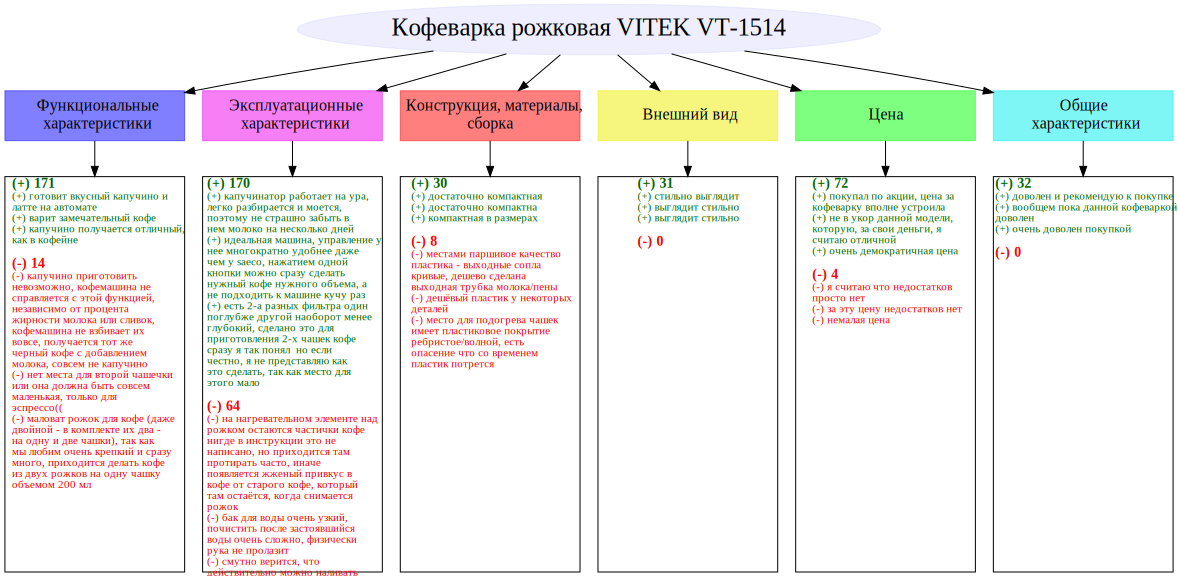

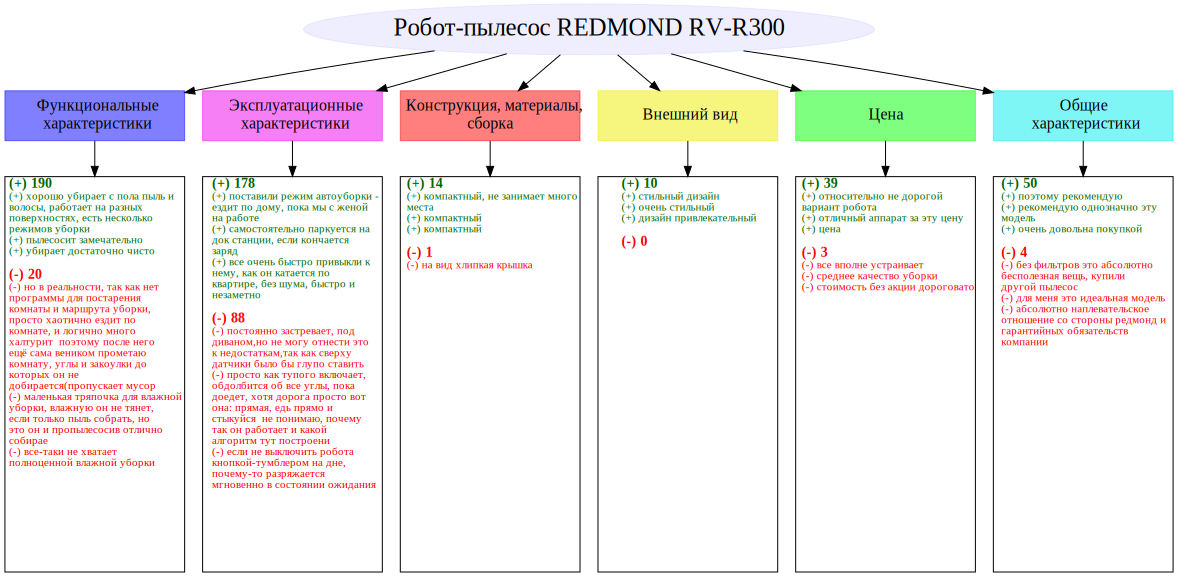

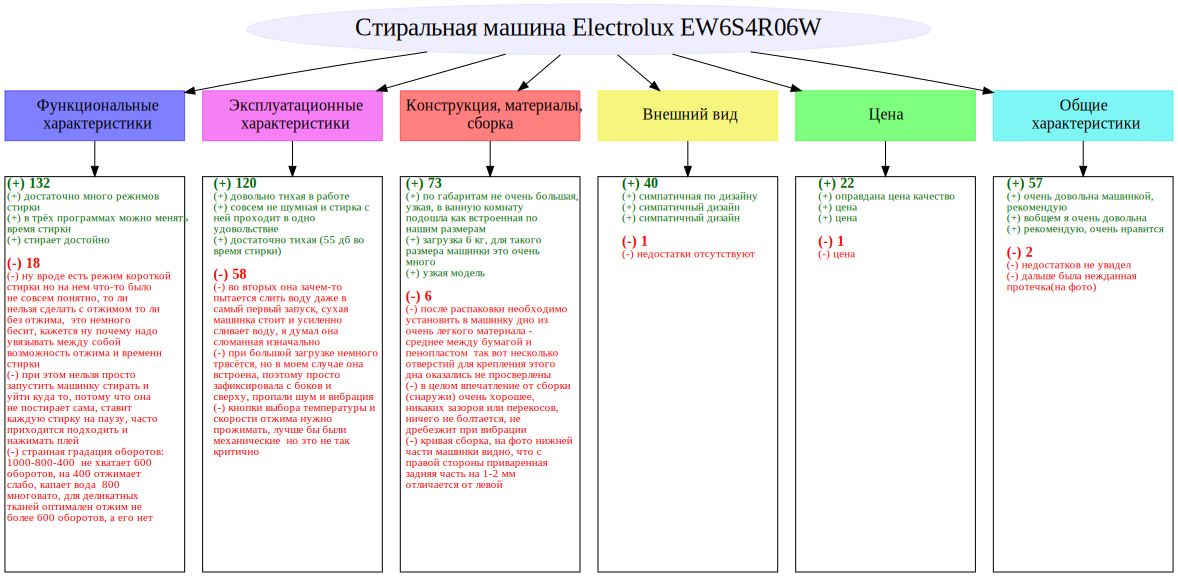

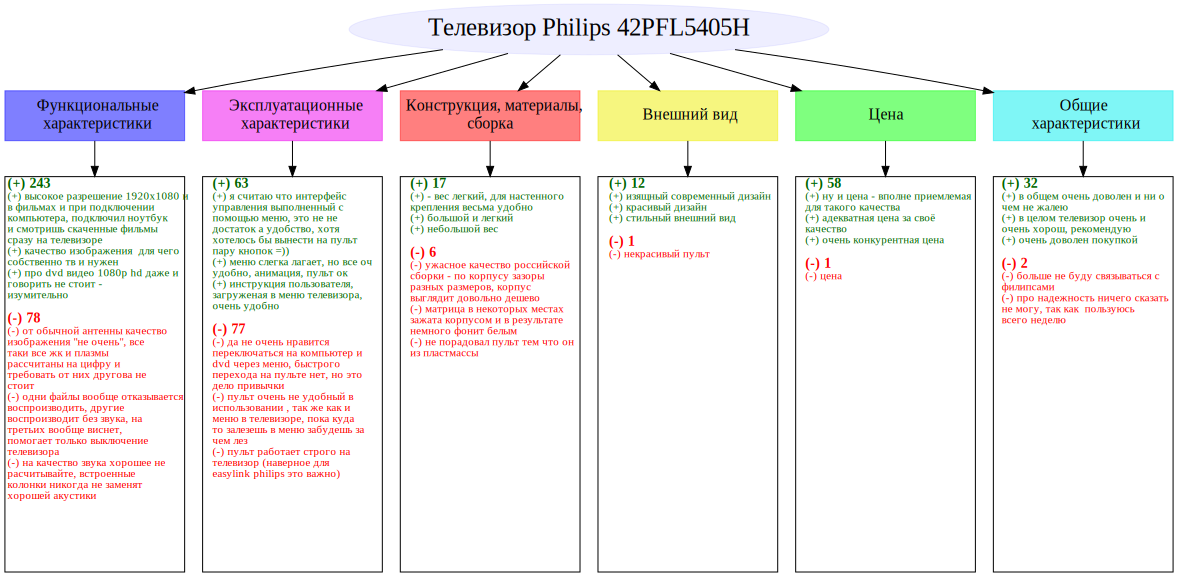

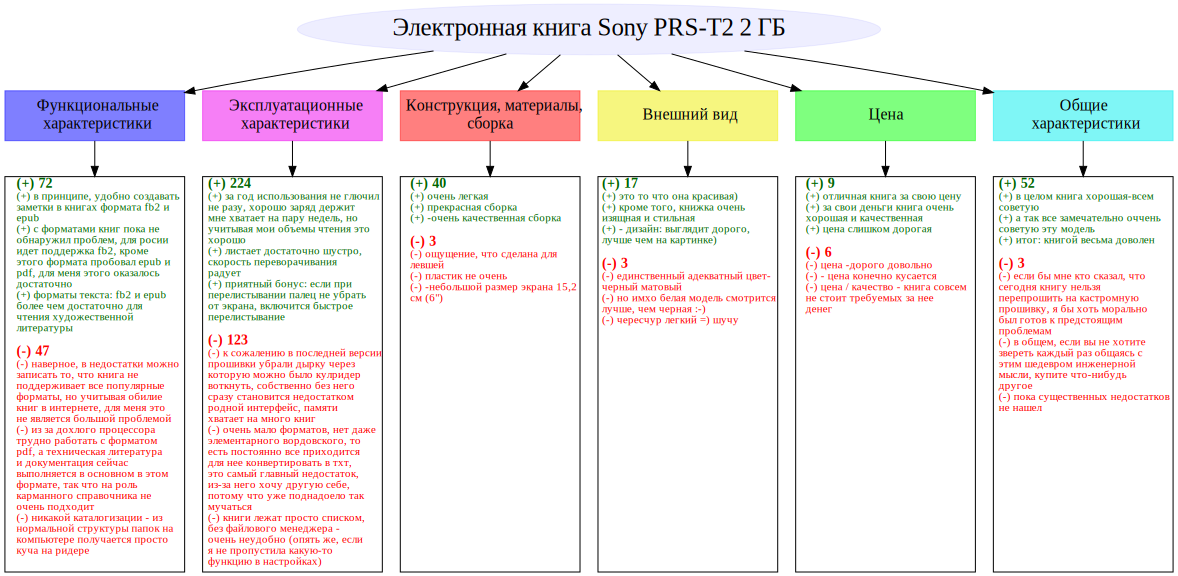

In [668]:
viz_data(graph_code, df_for_vis, rs)

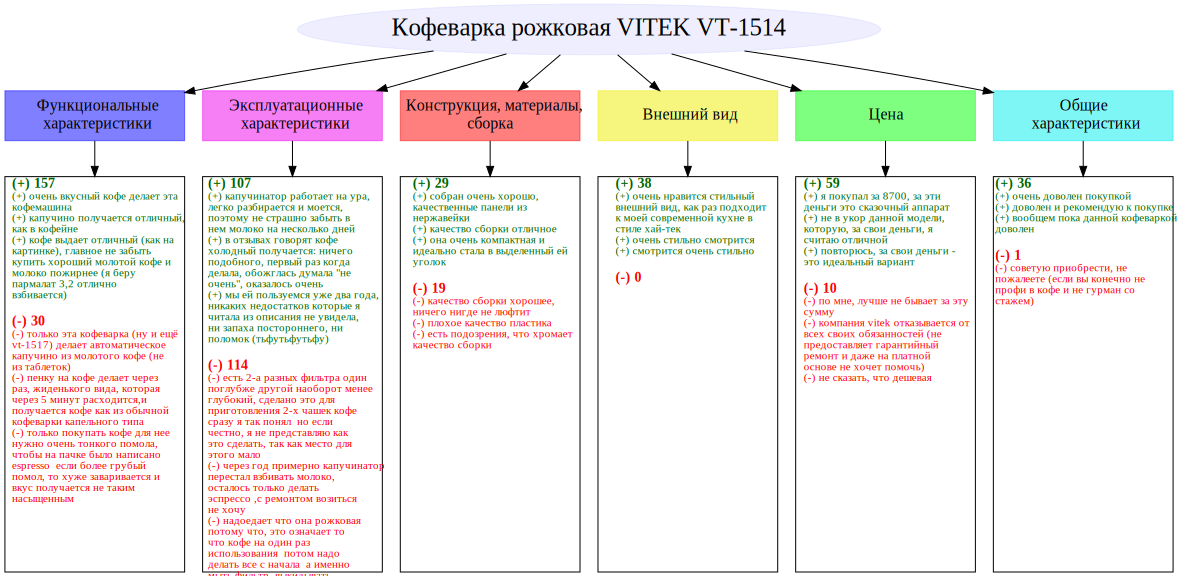

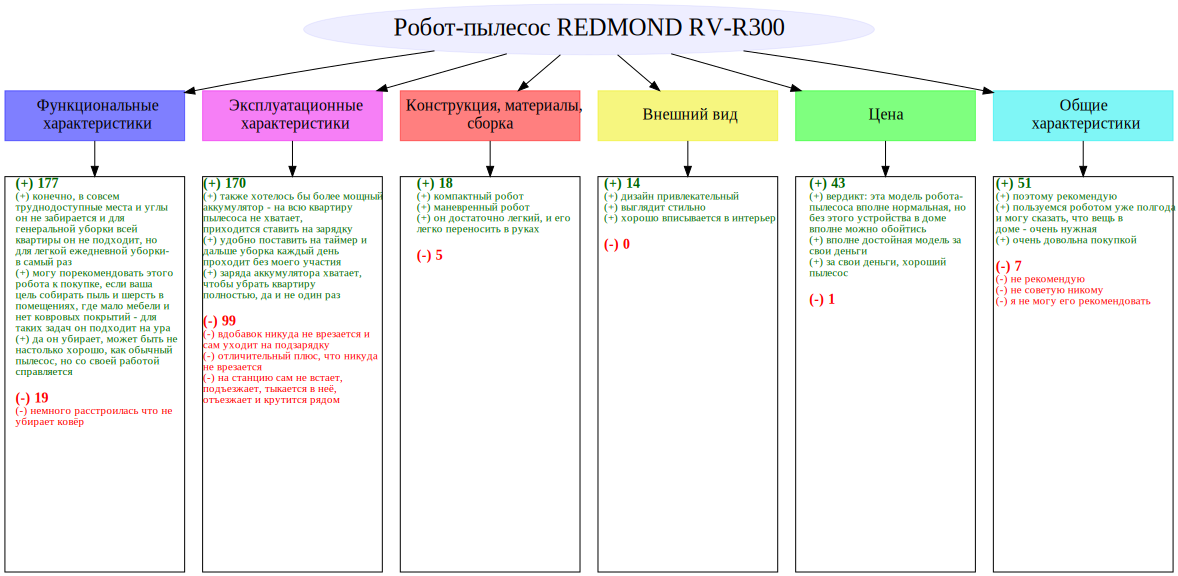

Error: syntax error in line 3 
... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...
in label of node N1
Error: syntax error in line 3 
... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...
in label of node N2
Error: syntax error in line 3 
... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...
in label of node N3
Error: syntax error in line 3 
... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...
in label of node N4
Error: syntax error in line 3 
... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...
in label of node N5
Error: syntax error in line 3 
... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...
in label of node N6


CalledProcessError: Command '['dot', '-Tsvg']' returned non-zero exit status 1. [stderr: b'Error: syntax error in line 3 \r\n... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...\r\nin label of node N1\r\nError: syntax error in line 3 \r\n... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...\r\nin label of node N2\r\nError: syntax error in line 3 \r\n... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...\r\nin label of node N3\r\nError: syntax error in line 3 \r\n... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...\r\nin label of node N4\r\nError: syntax error in line 3 \r\n... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...\r\nin label of node N5\r\nError: syntax error in line 3 \r\n... <FONT COLOR="darkgreen" POINT-SIZE="11"></FONT> ...\r\nin label of node N6\r\n']

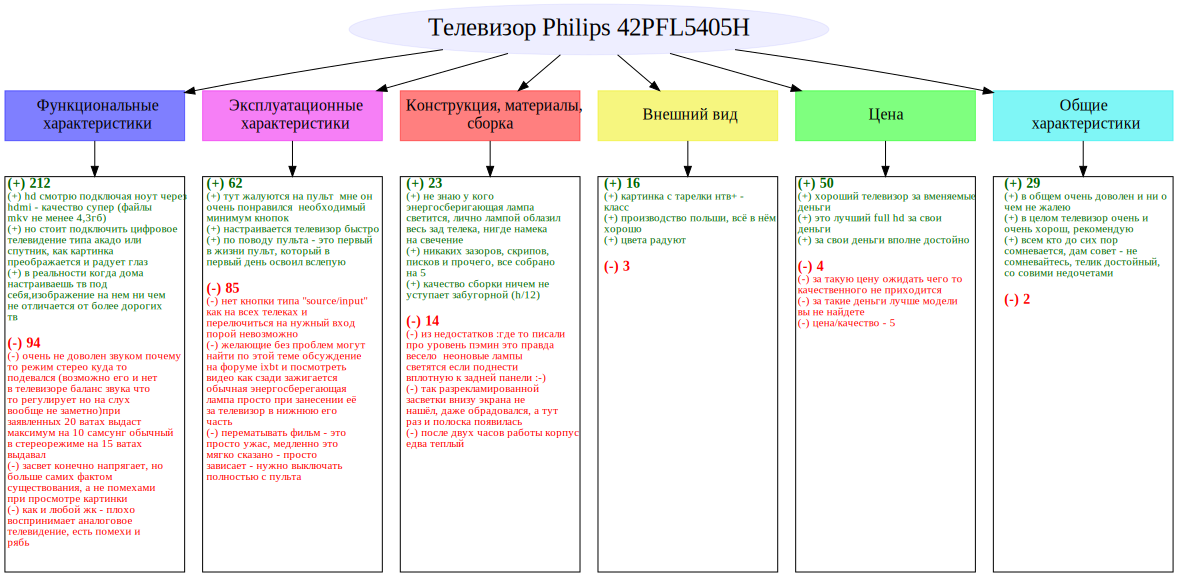

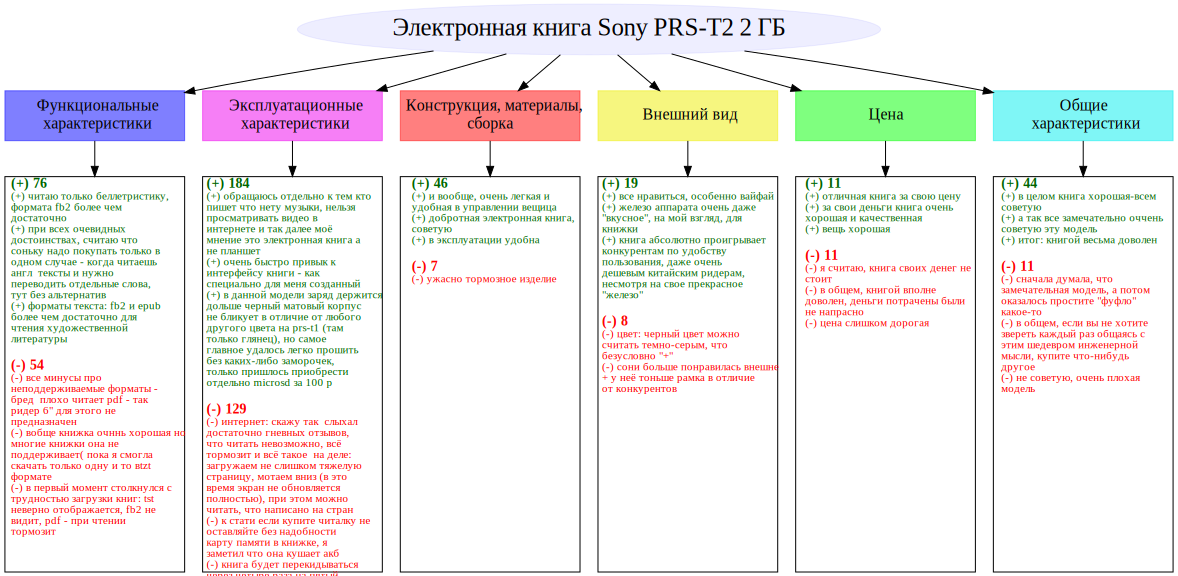

In [1678]:
viz_data(graph_code, df_for_vis, rs)